## Multi-class classification with logistic regression

In [1]:
%matplotlib inline
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
from sklearn.linear_model import LogisticRegression
import time
from IPython import display

In [2]:
IMAGE_SIZE = 20

#### Loading data from matlab file using scipy.io.loadmat()

In [3]:
train_data = io.loadmat("ex3data1.mat")
X = train_data['X']
y = train_data['y']

#### Change output label of "0" from "10" to "0" because python index start from 0 not 1 like MATLAB

In [4]:
y[y==10] = 0

Please note that the $reshape()$ function in NUMPY and MATLAB default behavior is different,
To make $reshape()$ in numpy behave the same we add flag order="F" when call reshape function in numpy

In [5]:
def display_data(data):
    m,n = data.shape
    row_width = int(np.sqrt(m))
    img_width = img_height = int(np.sqrt(n))
    img_show = np.empty((row_width*img_width, img_width*row_width))
    for i in range(row_width):
        for j in range(row_width):
            img_show[img_height*i:(img_height*i)+img_height, img_width*j:img_width*j + img_width] = \
            np.reshape(data[i*row_width + j, :], (img_height, img_width), order='F')
            
    plt.imshow(img_show)

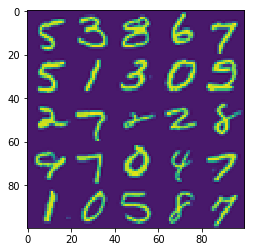

In [6]:
idx = np.random.randint(X.shape[0], size=25)
display_data(X[idx, :])

Compute logistic regression cost function and gradient

In [7]:
def sigmoid(value):
    return 1 / (1 + math.e ** (-value))

In [8]:
def lrCost(theta, X, y, _lambda=0):
#     print('theta', theta.shape, 'X', X.shape, 'y', y.shape)
    m,n = X.shape
    Z = np.dot(X, theta)
    H = sigmoid(Z)
    C = (1/m) * ( -np.dot(y.T, np.log(H)) - np.dot((1-y).T, np.log(1 - H) ))
    Regularization = (_lambda/(2*m)) * np.dot(theta[1:].T, theta[1:])
    
    return C + Regularization

Compute Gradient of Cost Function using batch gradient descent

In [13]:
def lrGradient(theta, X, y, alpha=1, _lambda=0):
    m,n = X.shape
    regularization = (_lambda/m) * theta[1:]
    z = np.dot(X, theta)
    grad_theta =  (alpha/m) * np.dot(X.T, (sigmoid(z) - np.reshape(y, (m, 1))))
    grad_theta[1:] = grad_theta[1:] + regularization
    return grad_theta

Training our 1 vs All logistic regression model with batch gradient descent

In [10]:
def oneVsAll(X, y, num_labels, alpha=1, _lambda=0, num_iteration=100):
    m,n = X.shape
    all_theta = np.zeros((n+1, num_labels))
    X = np.insert(X, 0, 1, axis=1)
    
    for i in range(num_labels):
        y_label = y.copy()
        # Convert y to binary vector for each labels
        # Example : if label = 5 then y vector value = 1 if the value at that index = 5 otherwise 0
        idx0 = y_label!=i
        idx1 = y_label==i
        y_label[idx1] = 1
        y_label[idx0] = 0
        
        # Use gradient descent to minimize the Cost of each output label
        for j in range(num_iteration):
            print('Label ' + str(i) + ',Iteration :' + str(j) + ', Cost : ' + str(lrCost(all_theta[:,[i]], X, y_label, _lambda)), end='\r')
            all_theta[:,[i]] = all_theta[:,[i]] - lrGradient(all_theta[:,[i]], X, y_label, alpha, _lambda)
            
        print('\n')
    return all_theta
        

Compute Gradient of Cost Function using stochastic gradient descent

In [14]:
index = np.arange(X.shape[0])

In [16]:
def lrStochasticGradient(theta, X, y, alpha=1, _lambda=0, batch_size=1):
    # Random shuffle our training set
    global index
    np.random.shuffle(index)
    m,n = X.shape
    for i in range(0, m, batch_size):
        theta = theta - lrGradient(theta, X[index[i:i+batch_size],:], y[index[i:i+batch_size]])
        
    return theta

Training our 1 vs All logistic regression model with stochastic gradient descent

In [60]:
def oneVsAll_Stochastic(X, y, num_labels, alpha=1, _lambda=0, stochastic_loop=1, batch_size=1):
    m,n = X.shape
    all_theta = np.zeros((n+1, num_labels))
    X = np.insert(X, 0, 1, axis=1)
    
    for i in range(num_labels):
        y_label = y.copy()
        # Convert y to binary vector for each labels
        # Example : if label = 5 then y vector value = 1 if the value at that index = 5 otherwise 0
        idx0 = y_label!=i
        idx1 = y_label==i
        y_label[idx1] = 1
        y_label[idx0] = 0
        
        # Using stochastic gradient descent to minimize the cost of each output label
        for _ in range(stochastic_loop):
            global index
            np.random.shuffle(index)
            for j in range(0, m, batch_size):
                grad = lrGradient(all_theta[:,[i]], X[index[j:j+batch_size],:], y_label[index[j:j+batch_size]])
                print('Label ' + str(i) + ', Cost : ' + str(lrCost(all_theta[:,[i]], X, y_label, _lambda)),  end='\r')
                all_theta[:,[i]] = all_theta[:,[i]] - grad
                
        print('\n')
    return all_theta

In [77]:
start = time.time()
weights = oneVsAll_Stochastic(X, y, 10, alpha=0.0001, _lambda=0, stochastic_loop=3, batch_size=10)
print(time.time()-start)

Label 0, Cost : [[ 0.01698565]]

Label 1, Cost : [[ 0.02775485]]

Label 2, Cost : [[ 0.11344252]]

Label 3, Cost : [[ 0.09902602]]

Label 4, Cost : [[ 0.06324806]]

Label 5, Cost : [[ 0.08355817]]

Label 6, Cost : [[ 0.03562962]]

Label 7, Cost : [[ 0.0499865]]]

Label 8, Cost : [[ 0.12146686]]

Label 9, Cost : [[ 0.10970733]]

76.0083475112915


In [40]:
def predict(thetas, image):
    output = np.dot(thetas.T, np.insert(image, 0, 1, axis=1).T)
    return sigmoid(output)

In [41]:
def accuracy(thetas, X, y):
    m,n = X.shape
    prediction = np.reshape(np.argmax(predict(thetas, X), axis=0), (m, 1))
    return (sum(prediction==y) / 5000) * 100

In [42]:
def visualizeAndPredict(thetas, image, labels):
    plt.imshow(np.reshape(image, (IMAGE_SIZE, IMAGE_SIZE), order='F'))
    print('Predict : ', np.argmax(predict(thetas, image)), 'Actual :', labels)

In [63]:
start = time.time()
thetas = oneVsAll(X, y, 10, alpha=1, _lambda=0, num_iteration=500)
print(time.time()-start)

Label 0,Iteration :499, Cost : [[ 0.02449941]]

Label 1,Iteration :499, Cost : [[ 0.03009351]]

Label 2,Iteration :499, Cost : [[ 0.0743258]]]

Label 3,Iteration :499, Cost : [[ 0.0776205]]]

Label 4,Iteration :499, Cost : [[ 0.05706481]]

Label 5,Iteration :499, Cost : [[ 0.08381673]]

Label 6,Iteration :499, Cost : [[ 0.03848541]]

Label 7,Iteration :499, Cost : [[ 0.05096093]]

Label 8,Iteration :499, Cost : [[ 0.10340191]]

Label 9,Iteration :499, Cost : [[ 0.0967233]]]

51.08192157745361


In [78]:
accuracy(weights, X, y)

array([ 91.08])

In [65]:
accuracy(thetas, X, y)

array([ 92.14])

Predict :  1 Actual : [[1]]


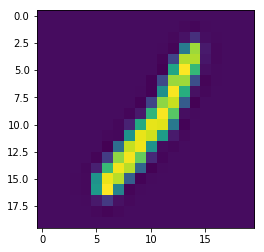

In [282]:
idx = np.random.randint(X.shape[0], size=1)
visualizeAndPredict(thetas, X[idx,:], y[idx])

#### Using Scikit-Learn Logistic regression to train our model

In [284]:
multi_lg = LogisticRegression()

In [305]:
multi_lg.fit(X, y.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [306]:
multi_lg.score(X, y)

0.94379999999999997

In [ ]:
def visualizeAndPredict_SK(thetas, image, labels):
    plt.imshow(np.reshape(image, (IMAGE_SIZE, IMAGE_SIZE), order='F'))
    display.clear_output(wait=True)
    display.display(plt.gcf())
    print('Predict : '+ str(multi_lg.predict(image))+ ',Actual :' + str(labels), end='\r')

Display images that our model's prediction is wrong

In [340]:
def visualizeWrongPredict(thetas, image, labels):
    prd = multi_lg.predict(image)
    if (prd != labels):
        visualizeAndPredict_SK(thetas, image, labels)
        time.sleep(3)

In [351]:
for i in range(X.shape[0]):
    visualizeWrongPredict(thetas, X[[i],:], y[i])